# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Feature transformations.
3. Training datasets creation - splitting into train, validation and test sets.
4. Loading the training data.
5. Training the model.
6. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

In [1]:
# Importing the packages for the needed libraries for the Jupyter notebook
import inspect 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

In [2]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

forecast_renewable_energy_fg = fs.get_feature_group(
    name='forecast_renewable_energy',
    version=1
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_holidays_fg = fs.get_feature_group(
    name='danish_holidayss',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `event_time` as `timestamp` in part 01 we can now join them together for the `electricity_fg`, `forecast_renewable_energy_fg`, `weather_fg` and `danish_holiday_fg` .

In [4]:
# Select features for training data
selected_features = electricity_fg.select_all()\
    .join(forecast_renewable_energy_fg.select_except(["timestamp", "time"]))\
    .join(weather_fg.select_except(["timestamp", "time"]))\
    .join(danish_holidays_fg.select_all())

In [5]:
# Uncomment this if you would like to view your selected features
# selected_features.show(5)

### <span style="color:#2656a3;"> 🤖 Transformation Functions</span>

We preprocess our data using *min-max scaling* on the numerical features and *label encoding* on the one categorical feature we have.
To achieve this, we create a mapping between our features and transformation functions. This ensures that transformation functions like min-max scaling are applied exclusively on the training data, preventing any data leakage into the validation or test sets.

To achieve this, we create a mapping between our features and transformation functions - ved ikke om man kan sige det her?

In [6]:
# Defining transformation functions for feature scaling and encoding
transformation_functions = {
        "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_offshore_wind_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_onshore_wind_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_solar_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "temperature_2m": fs.get_transformation_function(name="min_max_scaler"), 
        "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"), 
        "precipitation": fs.get_transformation_function(name="min_max_scaler"), 
        "rain": fs.get_transformation_function(name="min_max_scaler"), 
        "snowfall": fs.get_transformation_function(name="min_max_scaler"), 
        "weather_code": fs.get_transformation_function(name="min_max_scaler"), 
        "cloud_cover": fs.get_transformation_function(name="min_max_scaler"), 
        "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
        "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
        "type": fs.get_transformation_function(name="label_encoder"),
    }

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

We can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

ved ikke om den her omformulering af botten går an?

`Feature Views` serve as an intermediary between **Feature Groups** and the **Training Dataset**. By combining various **Feature Groups**, we can construct **Feature Views**, which retain metadata about our data. Utilizing **Feature Views**, we can subsequently generate a **Training Dataset**.

Feature Views facilitate the definition of schema through queries with filters, identification of the model's target feature or label, and application of additional transformation functions.

To create a Feature View, we employ the `FeatureStore.get_or_create_feature_view()` method, where we specify the following parameters:

- `name`: The name of the feature group.

- `version`: The version of the feature group.

- `labels`: Our target variable.

- `transformation_functions`: Functions to transform our features.

- `query`: A query object containing the relevant data.

In [7]:
# Getting or creating a feature view named 'electricity_feature_view'
version = 1 # Defining the version for the feature view
feature_view = fs.get_or_create_feature_view(
    name='electricity_feature_view',
    version=version,
    labels=[], # Labels will be defined manually later for our 'y'
    transformation_functions=transformation_functions,
    query=selected_features,
)

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `fs.create_training_dataset()` method.

**From feature view APIs you can also create training datasts based on even time filters specifing `start_time` and `end_time`** 

### <span style="color:#2656a3;"> ⛳️ Dataset with train, test and validation splits</span>

In [8]:
# Splitting the feature view data into train, validation, and test sets
# We didn't specify 'labels' in feature view creation, it will therefore return 'None' for Y
X_train, X_val, X_test, _, _, _ = feature_view.train_validation_test_split(
    train_start="2022-01-01",
    train_end="2023-06-30",
    validation_start="2023-07-01",
    validation_end="2023-09-30",
    test_start="2023-10-01",
    test_end="2023-12-31",
    description='Electricity price prediction dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.10s) 


In [9]:
# Sorting the training, validation, and test datasets based on the 'timestamp' column
X_train.sort_values(["timestamp"], inplace=True)
X_val.sort_values(["timestamp"], inplace=True)
X_test.sort_values(["timestamp"], inplace=True)

In [10]:
#X_train.info()

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Displaying the first 5 rows of the train dataset (X_train)
X_train[(X_train['timestamp'] == 1641024000000) ]

,timestamp,time,date,dk1_spotpricedkk_kwh,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,type
136,1641024000000,2022-01-01 08:00:00+00:00,2022-01-01,0.179598,0.538064,0.062463,0.000026,0.393182,0.973333,0.0,0.0,0.0,0.04,1.0,0.143434,0.109015,0


In [11]:
# Extracting the target variable 'dk1_spotpricedkk_kwh' and defineing 'y_train', 'y_val' and 'y_test' 
y_train = X_train[["dk1_spotpricedkk_kwh"]]
y_val = X_val[["dk1_spotpricedkk_kwh"]]
y_test = X_test[["dk1_spotpricedkk_kwh"]]

In [12]:
# Displaying the first 5 rows of the train dataset (X_train)
y_train.head()

,dk1_spotpricedkk_kwh
136,0.179598
5272,0.199962
3946,0.206692
7995,0.213993
8169,0.224618


In [13]:
# Dropping the 'date', 'time' and 'timestamp' columns from the training, validation, and test datasets
X_train.drop(["date", "time", "timestamp"], axis=1, inplace=True)
X_val.drop(["date", "time", "timestamp"], axis=1, inplace=True)
X_test.drop(["date", "time", "timestamp"], axis=1, inplace=True)

In [14]:
# # Dropping the 'dare', 'time' and 'timestamp' and dependent variable (y) columns from the training, validation, and test datasets
# X_train.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
# X_val.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
# X_test.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)

In [15]:
# Displaying the first 5 rows of the train dataset (X_train)
X_train.head()

,dk1_spotpricedkk_kwh,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,type
136,0.179598,0.538064,0.062463,0.000026,0.393182,0.973333,0.0,0.0,0.0,0.04,1.0,0.143434,0.109015,0
5272,0.199962,0.404354,0.051654,0.002581,0.393182,0.986667,0.0,0.0,0.0,0.04,1.0,0.096970,0.109015,0
3946,0.206692,0.272990,0.046760,0.010849,0.402273,0.973333,0.0,0.0,0.0,0.04,1.0,0.094949,0.071279,0
7995,0.213993,0.282117,0.052855,0.019040,0.406818,0.933333,0.0,0.0,0.0,0.04,1.0,0.082828,0.068134,0
8169,0.224618,0.312832,0.073474,0.020270,0.409091,0.933333,0.0,0.0,0.0,0.04,1.0,0.177778,0.132075,0


In [16]:
# Displaying the first 5 rows of the train dataset (y_train)
y_train.head()

,dk1_spotpricedkk_kwh
136,0.179598
5272,0.199962
3946,0.206692
7995,0.213993
8169,0.224618


## <span style="color:#2656a3;">🗃 Window timeseries dataset </span>

## <span style="color:#2656a3;">🧬 Modeling</span>

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os

In [18]:
# Dropping the 'dare', 'time' and 'timestamp' and dependent variable (y) columns from the training, validation, and test datasets
X_train.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
X_val.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
X_test.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)

In [19]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor()

In [20]:
# Train the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
# Make predictions on the validation set
y_test_pred = model.predict(X_test)

In [22]:
# Calculate RMSE on the validation set
mse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.11361252479607802


In [23]:
mean_error = mean_absolute_error(y_test, y_test_pred)
display(mean_error)

0.09137652681513682

## <span style="color:#2656a3;">🔧 Fine tuning</span>

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


In [25]:
params = {
    # TODO: we could parametrize data prep too and test some combinations
    # TODO: check params for search grid
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6],
    'xgb__min_child_weight': [0.5, 1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.001, 0.1, 0.2 , 0.3, 0.4],
    'xgb__colsample_bytree': [0.5, 0.7, 0.9, 1, 1.5, 2],
}

In [26]:
gs_xgb = RandomizedSearchCV(estimator=model, param_distributions=params, verbose=3, cv=5, n_jobs=-1)

In [27]:
# Train the fine tuned model on the training data
gs_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.5, 0.7, 0.9,
                                                                  1, 1.5, 2],
                                        'xgb__gamma': [0.0, 0.001, 0.1, 0.2,
                                                       0.3, 0.4],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [3, 4, 5, 6],
                                        'xgb__min_child_weight': [0.5, 1, 3, 5,
                                                                  7]},
                   verbose=3)

In [28]:
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'xgb__min_child_weight': 1,
 'xgb__max_depth': 5,
 'xgb__learning_rate': 0.2,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 2}

-2.8568741216703204

In [29]:
# Make predictions on the validation set
gs_model = gs_xgb.best_estimator_

In [30]:
# get predictions for test set to get a performance estimate for unseen data
# best model is already re-trained on whole training data! (default for refit=True)
y_pred = gs_model.predict(X_val)
mean_error = mean_absolute_error(y_val, y_pred)
display(mean_error)

0.1899297740713606

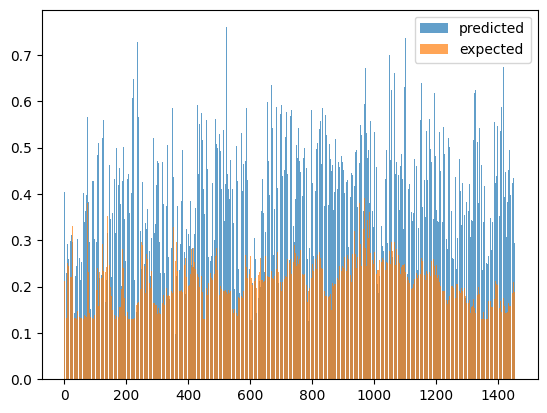

In [31]:
plt.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
plt.bar(x=np.arange(len(y_pred)), height=y_test['dk1_spotpricedkk_kwh'].to_numpy(), label='expected', alpha=0.7)
plt.legend()
plt.show() 

## <span style='color:#2656a3'>🗄 Model Registry</span>

In [32]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

In [33]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [34]:
# Retrieving the Model Registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [35]:
# Exporting the trained model to a directory
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [36]:
joblib.dump(model, model_dir + "\dk_electricity_model.pkl")

['model\\dk_electricity_model.pkl']

In [37]:
# Create an entry in the model registry that includes the model's name, desc, metrics
xgb_model = mr.python.create_model(
    name="electricity_price_prediction_model",
    metrics={"mean_absolute_error": mean_error},
    model_schema=model_schema,
    input_example=X_train.sample(),
    description="DK1 Electricity Price Predictor"
)

In [38]:
# Upload to hopsworks
xgb_model.save(model_dir)

Uploading: 100.000%|██████████| 432933/432933 elapsed<00:02 remaining<00:00  3.43it/s]
Uploading: 100.000%|██████████| 174/174 elapsed<00:01 remaining<00:00<00:05,  1.40s/it]
Uploading: 100.000%|██████████| 1297/1297 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/556180/models/electricity_price_prediction_model/1


Model(name: 'electricity_price_prediction_model', version: 1)

## <span style='color:#2656a3'>🚀 Model Deployment</span>

In [110]:
%%writefile predict_example.py
import os
import numpy as np
import pandas as pd
import hsfs
import joblib


class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # get feature view
        self.fv = self.fs.get_feature_view("electricity_feature_view", 1)
        
        # initialize serving
        self.fv.init_serving(1)

        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/dk_electricity_model.pkl")
        print("Initialization Complete")

    
    def predict(self, timestamp_value, date_value):
        """ Serves a prediction request usign a trained model"""
        # Retrieve feature vectors
        feature_vector = self.fv.get_feature_vector(
            entry = {['timestamp','date']: [timestamp_value[0], date_value[0]]}
        )
        return self.model.predict(np.asarray(feature_vector[1:]).reshape(1, -1)).tolist()

Writing predict_example.py


In [111]:
# Get the dataset API from the project
dataset_api = project.get_dataset_api()

# Upload the file "predict_example.py" to the "Models" dataset, overwriting if it already exists
uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)

# Create the full path to the uploaded predictor script
# predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)
predictor_script_path = "/Projects/benjami3/Models/predict_example.py"



Uploading: 100.000%|██████████| 1095/1095 elapsed<00:01 remaining<00:00


In [ ]:
/Projects/benjami3/Models/predict_example.py

## <span style='color:#2656a3'> 🚀 Create the deployment

In [112]:
# Give it any name you want
deployment = xgb_model.deploy(
    name="electricitypricedeployment", 
#    model_server="PYTHON",
    serving_tool="KSERVE",
    script_file=predictor_script_path
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/556180/deployments/249859
Before making predictions, start the deployment by using `.start()`


In [113]:
print("Deployment: " + deployment.name)
deployment.describe()

Deployment: electricitypricedeployment
{
    "artifact_version": 5,
    "batching_configuration": {
        "batching_enabled": false
    },
    "created": "2024-04-29T12:31:28.865Z",
    "creator": "Benjamin Ly",
    "description": null,
    "id": 249859,
    "inference_logging": "NONE",
    "model_framework": "PYTHON",
    "model_name": "electricity_price_prediction_model",
    "model_path": "/Projects/benjami3/Models/electricity_price_prediction_model",
    "model_server": "PYTHON",
    "model_version": 1,
    "name": "electricitypricedeployment",
    "predictor": "predict_example.py",
    "predictor_resources": {
        "limits": {
            "cores": 0.5,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 0.2,
            "gpus": 0,
            "memory": 32
        }
    },
    "requested_instances": 0,
    "serving_tool": "KSERVE"
}


In [114]:
deployment.start()














Deployment is ready: 100%|██████████| 5/5 [00:47<00:00,  9.53s/it]

Start making predictions by using `.predict()`


In [109]:
deployment.get_logs(component='predictor')

Explore all the logs and filters in the Kibana logs at https://c.app.hopsworks.ai:443/p/556180/deployments/251905

Instance name: electricitypricedeployment-predictor-default-00001-deploymgtc8q
  File "/serving/predictor/../kserve-component-server.py", line 184, in <module>
    spec.loader.exec_module(mod)
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/mnt/models/predictor-predict_example.py", line 31
    entry = {'timestamp','date': timestamp_value[0], date_value[0]}
                               ^
SyntaxError: invalid syntax




In [115]:
# Get the current state of the deployment and describe it
deployment_state = deployment.get_state().describe()

{
    "available_instances": 1,
    "available_transformer_instances": 0,
    "condition": {
        "reason": "Deployment is ready",
        "status": true,
        "type": "READY"
    },
    "deployed": "2024-04-29T12:31:52.000Z",
    "hopsworks_inference_path": "/project/556180/inference/models/electricitypricedeployment",
    "model_server_inference_path": "/v1/models/electricitypricedeployment",
    "revision": "08297517",
    "status": "Running"
}


In [124]:
deployment.predict({'instances': [1640995200000]})

TypeError: Object of type datetime is not JSON serializable

In [120]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://c.app.hopsworks.ai:443/p/556180/deployments/249859

Instance name: electricitypricedeployment-predictor-default-00001-deploym54ppf
    response, response_headers = await self.dataplane.infer(model_name=model_name, body=body, headers=headers)
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/kserve/protocol/dataplane.py", line 276, in infer
    response = await model(body, headers=headers)
  File "/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/kserve/model.py", line 117, in __call__
    else self.predict(payload, headers)
  File "/serving/predictor/../kserve-component-server.py", line 64, in wrapper
    parse_exception(err)
  File "/serving/predictor/../kserve-component-server.py", line 54, in parse_exception
    raise tornado.web.HTTPError(
tornado.web.HTTPError: HTTP 500: Predict.predict() missing 1 required positional argument: 'date_value'




## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

In the next notebook you will use your registered model to predict batch data.